# Expérimentation et sélection de modèles pour la prédiction des prix des maisons

Ce notebook présente la phase d'expérimentation et de sélection des modèles de machine learning pour la prédiction des prix des maisons à Ames, Iowa. Il s'appuie sur les résultats de l'analyse exploratoire pour construire, entraîner et évaluer différents modèles de régression.

## Objectifs de l'expérimentation :
1. **Préparation des données** : Nettoyage, transformation et préparation du jeu de données pour la modélisation
2. **Construction du pipeline de prétraitement** : Mise en place d'un pipeline robuste pour le traitement des données
3. **Expérimentation de modèles** : Test de différents algorithmes de régression
4. **Évaluation et comparaison** : Analyse des performances avec des métriques appropriées
5. **Suivi avec MLFlow** : Enregistrement des expériences pour la traçabilité
6. **Sélection du modèle final** : Choix du meilleur modèle basé sur les performances
7. **Analyse des résidus** : Validation des hypothèses du modèle sélectionné
8. **Sauvegarde du modèle** : Préparation pour le déploiement


# Importation des librairies

In [1]:
# Librairies pour la manipulation des données
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
import json
import pickle

# Librairies pour le machine learning
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
)
from sklearn.preprocessing import (
    RobustScaler,
    OneHotEncoder,
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modèles de régression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor,
)
from sklearn.svm import SVR

# Métriques d'évaluation
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
    explained_variance_score,
)

# Librairies pour la visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Librairies pour l'analyse des modèles

# MLFlow pour le suivi des expériences
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

# Librairies pour le logging et la configuration
from loguru import logger
import sys
import pendulum
from scipy import stats

warnings.filterwarnings("ignore")

# Configuration du logger
log_fmt = "<green>{time:YYYY-MM-DD HH:mm:ss.SSS!UTC}</green> | <level>{level: <8}</level> | <cyan>{name}</cyan>:<cyan>{function}</cyan>:<cyan>{line}</cyan> - {message}"
logger.configure(handlers=[{"sink": sys.stderr, "format": log_fmt}])

# Configuration des graphiques
plt.style.use("default")
sns.set_palette("husl")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

# Variables globales
CURRENT_DATE = pendulum.now(tz="UTC")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

logger.info("Toutes les librairies ont été importées avec succès")

2025-07-30 21:39:42.027 | INFO     | __main__:<module>:75 - Toutes les librairies ont été importées avec succès


# Configuration des chemins et paramètres

In [2]:
# Définition des chemins
PROJECT_DIR = Path.cwd()
DATA_DIR = PROJECT_DIR / "house_price_dataset"
OUTPUT_DIR = PROJECT_DIR / "output_files"
MODELS_DIR = PROJECT_DIR / "models"
REPORTS_DIR = PROJECT_DIR / "reports"

# Création des répertoires s'ils n'existent pas
for directory in [OUTPUT_DIR, MODELS_DIR, REPORTS_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

# Paramètres de l'expérimentation
TARGET_VARIABLE = "SalePrice"
TEST_SIZE = 0.2
CV_FOLDS = 5
FIGSIZE_LARGE = (15, 8)
FIGSIZE_MEDIUM = (12, 6)
FIGSIZE_SMALL = (10, 5)

# Configuration MLFlow
EXPERIMENT_NAME = "House Price Prediction"
mlflow.set_experiment(EXPERIMENT_NAME)

logger.info("Configuration terminée")
logger.info(f"Répertoire du projet: {PROJECT_DIR}")
logger.info(f"Répertoire des modèles: {MODELS_DIR}")
logger.info(f"Variable cible: {TARGET_VARIABLE}")
logger.info(f"Expérience MLFlow: {EXPERIMENT_NAME}")

2025-07-30 21:40:22.495 | INFO     | __main__:<module>:24 - Configuration terminée
2025-07-30 21:40:22.495 | INFO     | __main__:<module>:25 - Répertoire du projet: d:\Documents\IT\mlops_house_price_prediction\notebooks
2025-07-30 21:40:22.495 | INFO     | __main__:<module>:26 - Répertoire des modèles: d:\Documents\IT\mlops_house_price_prediction\notebooks\models
2025-07-30 21:40:22.495 | INFO     | __main__:<module>:27 - Variable cible: SalePrice
2025-07-30 21:40:22.495 | INFO     | __main__:<module>:28 - Expérience MLFlow: House Price Prediction


# Chargement et préparation des données

In [3]:
print("\n=== CHARGEMENT DES DONNÉES ===")

# Tentative de chargement du dataset enrichi depuis l'analyse exploratoire
enriched_file = OUTPUT_DIR / "house_price_01_analyse_dataset_enrichi.csv"
original_file = DATA_DIR / "ames_housing.csv"

if enriched_file.exists():
    df = pd.read_csv(enriched_file)
    logger.info(f"Dataset enrichi chargé depuis: {enriched_file}")
    print(f"Dataset enrichi chargé: {df.shape[0]:,} lignes, {df.shape[1]:,} colonnes")
else:
    df = pd.read_csv(original_file)
    logger.info(f"Dataset original chargé depuis: {original_file}")
    print(f"Dataset original chargé: {df.shape[0]:,} lignes, {df.shape[1]:,} colonnes")

    # Création rapide de quelques features importantes si le dataset enrichi n'existe pas
    if "YearBuilt" in df.columns and "YrSold" in df.columns:
        df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
        logger.info("Feature 'HouseAge' créée")

    if "TotalBsmtSF" in df.columns:
        df["HasBasement"] = (df["TotalBsmtSF"] > 0).astype(int)
        logger.info("Feature 'HasBasement' créée")

# Vérification de la variable cible
if TARGET_VARIABLE not in df.columns:
    logger.error(f"Variable cible '{TARGET_VARIABLE}' non trouvée dans le dataset")
    raise ValueError(f"Variable cible '{TARGET_VARIABLE}' manquante")

print(f"\nVariable cible '{TARGET_VARIABLE}' - Statistiques:")
print(df[TARGET_VARIABLE].describe())

# Chargement des métadonnées de l'analyse exploratoire si disponibles
metadata_file = OUTPUT_DIR / "house_price_01_analyse_metadata.json"
if metadata_file.exists():
    with open(metadata_file, "r") as f:
        analysis_metadata = json.load(f)
    logger.info("Métadonnées de l'analyse exploratoire chargées")

    # Utiliser les features recommandées si disponibles
    if "top_numeric_features" in analysis_metadata:
        recommended_features = analysis_metadata["top_numeric_features"]
        print(f"Features numériques recommandées trouvées: {len(recommended_features)}")
    else:
        recommended_features = None
else:
    analysis_metadata = None
    recommended_features = None
    logger.warning("Métadonnées de l'analyse exploratoire non trouvées")

logger.info("Chargement des données terminé")


=== CHARGEMENT DES DONNÉES ===


2025-07-30 21:40:29.877 | INFO     | __main__:<module>:9 - Dataset enrichi chargé depuis: d:\Documents\IT\mlops_house_price_prediction\notebooks\output_files\house_price_01_analyse_dataset_enrichi.csv
2025-07-30 21:40:30.058 | INFO     | __main__:<module>:38 - Métadonnées de l'analyse exploratoire chargées
2025-07-30 21:40:30.058 | INFO     | __main__:<module>:51 - Chargement des données terminé


Dataset enrichi chargé: 1,460 lignes, 90 colonnes

Variable cible 'SalePrice' - Statistiques:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
Features numériques recommandées trouvées: 15


# Préparation et division des données


=== PRÉPARATION DES DONNÉES ===
Forme des features (X): (1460, 89)
Forme de la variable cible (y): (1460,)

Distribution de la variable cible:
Moyenne: $180,921.20
Médiane: $163,000.00
Écart-type: $79,442.50
Skewness: 1.881

Transformation log appliquée (skewness > 0.5)
Skewness après transformation: 0.121


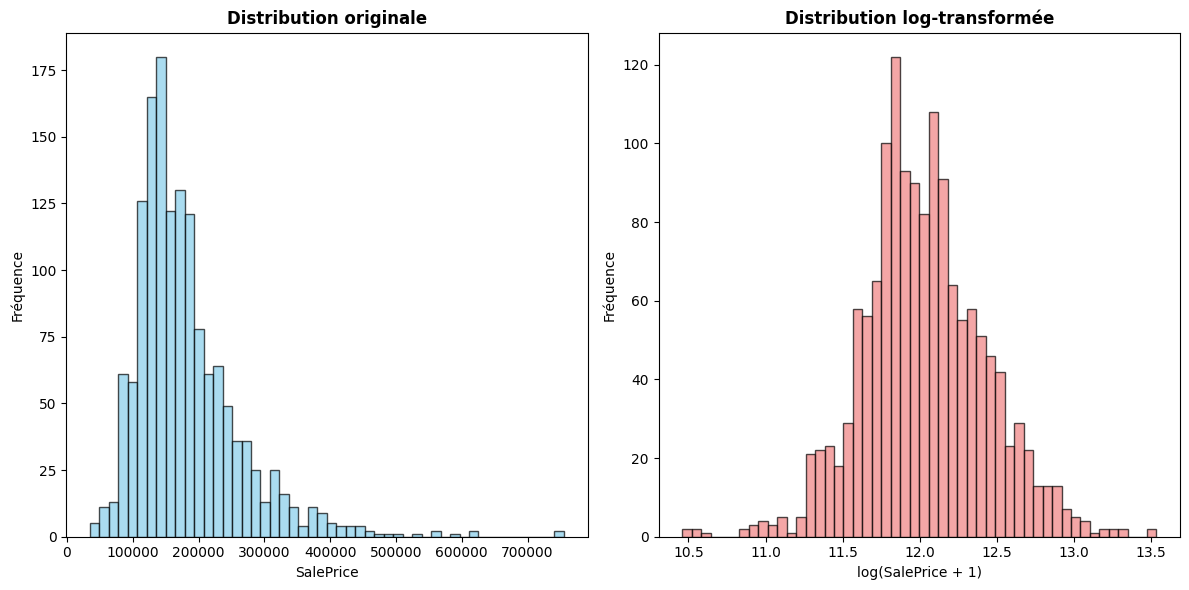

2025-07-30 21:40:34.254 | INFO     | __main__:<module>:42 - Transformation log appliquée à la variable cible
2025-07-30 21:40:34.319 | INFO     | __main__:<module>:113 - Préparation des données terminée. Features: 52, Échantillons train: 1168



Types de variables:
Variables numériques: 46
Variables catégorielles: 43
Utilisation des features numériques recommandées: 15
Variables catégorielles filtrées: 37

Features sélectionnées pour la modélisation: 52
- Numériques: 15
- Catégorielles: 37

Division des données:
Entraînement: 1,168 échantillons
Test: 292 échantillons
Proportion test: 20.0%


In [4]:
print("\n=== PRÉPARATION DES DONNÉES ===")

# Séparation des features et de la variable cible
X = df.drop(columns=[TARGET_VARIABLE])
y = df[TARGET_VARIABLE].copy()

print(f"Forme des features (X): {X.shape}")
print(f"Forme de la variable cible (y): {y.shape}")

# Analyse de la distribution de la variable cible
print("\nDistribution de la variable cible:")
print(f"Moyenne: ${y.mean():,.2f}")
print(f"Médiane: ${y.median():,.2f}")
print(f"Écart-type: ${y.std():,.2f}")
print(f"Skewness: {stats.skew(y):.3f}")

# Transformation log de la variable cible si elle est asymétrique
if abs(stats.skew(y)) > 0.5:
    y_log = np.log1p(y)  # log(1 + y) pour éviter les problèmes avec les valeurs nulles
    print("\nTransformation log appliquée (skewness > 0.5)")
    print(f"Skewness après transformation: {stats.skew(y_log):.3f}")

    # Visualisation de l'effet de la transformation
    fig, axes = plt.subplots(1, 2, figsize=FIGSIZE_MEDIUM)

    axes[0].hist(y, bins=50, alpha=0.7, color="skyblue", edgecolor="black")
    axes[0].set_title("Distribution originale", fontweight="bold")
    axes[0].set_xlabel(TARGET_VARIABLE)
    axes[0].set_ylabel("Fréquence")

    axes[1].hist(y_log, bins=50, alpha=0.7, color="lightcoral", edgecolor="black")
    axes[1].set_title("Distribution log-transformée", fontweight="bold")
    axes[1].set_xlabel(f"log({TARGET_VARIABLE} + 1)")
    axes[1].set_ylabel("Fréquence")

    plt.tight_layout()
    plt.show()

    # Utiliser la variable transformée pour la modélisation
    y_model = y_log
    use_log_transform = True
    logger.info("Transformation log appliquée à la variable cible")
else:
    y_model = y
    use_log_transform = False
    logger.info("Pas de transformation appliquée à la variable cible")

# Identification des types de variables
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("\nTypes de variables:")
print(f"Variables numériques: {len(numeric_features)}")
print(f"Variables catégorielles: {len(categorical_features)}")

# Sélection des features importantes si disponibles
if recommended_features:
    # Garder seulement les features recommandées qui existent dans le dataset
    available_recommended = [f for f in recommended_features if f in numeric_features]
    if len(available_recommended) > 0:
        numeric_features = available_recommended
        print(
            f"Utilisation des features numériques recommandées: {len(numeric_features)}"
        )

# Limiter les variables catégorielles à celles avec une cardinalité raisonnable
categorical_features_filtered = []
for col in categorical_features:
    unique_count = X[col].nunique()
    missing_pct = X[col].isnull().sum() / len(X)

    if (
        unique_count <= 20 and missing_pct < 0.5
    ):  # Max 20 catégories, moins de 50% de valeurs manquantes
        categorical_features_filtered.append(col)

categorical_features = categorical_features_filtered
print(f"Variables catégorielles filtrées: {len(categorical_features)}")

# Sélection finale des features
selected_features = numeric_features + categorical_features
X_selected = X[selected_features].copy()

print(f"\nFeatures sélectionnées pour la modélisation: {len(selected_features)}")
print(f"- Numériques: {len(numeric_features)}")
print(f"- Catégorielles: {len(categorical_features)}")

# Division train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_selected,
    y_model,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=None,  # Pas de stratification pour la régression
)

print("\nDivision des données:")
print(f"Entraînement: {X_train.shape[0]:,} échantillons")
print(f"Test: {X_test.shape[0]:,} échantillons")
print(f"Proportion test: {X_test.shape[0]/len(X_selected):.1%}")

# Sauvegarde des informations de préparation
preparation_info = {
    "target_variable": TARGET_VARIABLE,
    "use_log_transform": use_log_transform,
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
    "train_size": X_train.shape[0],
    "test_size": X_test.shape[0],
    "total_features": len(selected_features),
}

logger.info(
    f"Préparation des données terminée. Features: {len(selected_features)}, Échantillons train: {X_train.shape[0]}"
)

# Construction du pipeline de prétraitement

In [5]:
print("\n=== CONSTRUCTION DU PIPELINE DE PRÉTRAITEMENT ===")

# Pipeline pour les variables numériques
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),  # Imputation par la médiane
        ("scaler", RobustScaler()),  # Normalisation robuste aux outliers
    ]
)

# Pipeline pour les variables catégorielles
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),  # Imputation par le mode
        (
            "onehot",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        ),  # Encodage one-hot
    ]
)

# Combinaison des transformateurs
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",  # Supprimer les colonnes non spécifiées
)

print("Pipeline de prétraitement créé:")
print("- Transformateur numérique: Imputation (médiane) + RobustScaler")
print("- Transformateur catégoriel: Imputation (mode) + OneHotEncoder")
print(f"- Variables numériques traitées: {len(numeric_features)}")
print(f"- Variables catégorielles traitées: {len(categorical_features)}")

# Test du pipeline sur les données d'entraînement
print("\nTest du pipeline de prétraitement...")
try:
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    print("Forme après prétraitement:")
    print(f"- Entraînement: {X_train_processed.shape}")
    print(f"- Test: {X_test_processed.shape}")

    # Vérification des valeurs manquantes
    train_missing = np.isnan(X_train_processed).sum()
    test_missing = np.isnan(X_test_processed).sum()

    print("Valeurs manquantes après prétraitement:")
    print(f"- Entraînement: {train_missing}")
    print(f"- Test: {test_missing}")

    if train_missing == 0 and test_missing == 0:
        print("✅ Pipeline de prétraitement validé - Aucune valeur manquante")
        logger.info("Pipeline de prétraitement validé avec succès")
    else:
        logger.warning("Valeurs manquantes détectées après prétraitement")

except Exception as e:
    logger.error(f"Erreur lors du test du pipeline: {e}")
    raise

# Obtenir les noms des features après transformation
try:
    # Noms des features numériques (inchangés)
    numeric_feature_names = numeric_features

    # Noms des features catégorielles après one-hot encoding
    categorical_feature_names = []
    if len(categorical_features) > 0:
        # Fit le transformateur pour obtenir les noms des features
        cat_transformer = preprocessor.named_transformers_["cat"]
        onehot_encoder = cat_transformer.named_steps["onehot"]

        for i, feature in enumerate(categorical_features):
            categories = onehot_encoder.categories_[i]
            for category in categories:
                categorical_feature_names.append(f"{feature}_{category}")

    all_feature_names = numeric_feature_names + categorical_feature_names
    print(f"\nNombre total de features après transformation: {len(all_feature_names)}")

    if len(categorical_feature_names) > 0:
        print(
            f"Features catégorielles créées par one-hot encoding: {len(categorical_feature_names)}"
        )
        print(f"Exemples: {categorical_feature_names[:5]}...")

except Exception as e:
    logger.warning(f"Impossible d'obtenir les noms des features: {e}")
    all_feature_names = [f"feature_{i}" for i in range(X_train_processed.shape[1])]

logger.info(
    f"Pipeline de prétraitement construit. Features finales: {X_train_processed.shape[1]}"
)


=== CONSTRUCTION DU PIPELINE DE PRÉTRAITEMENT ===
Pipeline de prétraitement créé:
- Transformateur numérique: Imputation (médiane) + RobustScaler
- Transformateur catégoriel: Imputation (mode) + OneHotEncoder
- Variables numériques traitées: 15
- Variables catégorielles traitées: 37

Test du pipeline de prétraitement...


2025-07-30 21:40:37.738 | INFO     | __main__:<module>:57 - Pipeline de prétraitement validé avec succès
2025-07-30 21:40:37.738 | INFO     | __main__:<module>:95 - Pipeline de prétraitement construit. Features finales: 223


Forme après prétraitement:
- Entraînement: (1168, 223)
- Test: (292, 223)
Valeurs manquantes après prétraitement:
- Entraînement: 0
- Test: 0
✅ Pipeline de prétraitement validé - Aucune valeur manquante

Nombre total de features après transformation: 223
Features catégorielles créées par one-hot encoding: 208
Exemples: ["MSZoning_'C (all)'", 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM']...


# Définition des modèles à tester

In [ ]:
print("\n=== DÉFINITION DES MODÈLES À TESTER ===")

# Dictionnaire des modèles avec leurs hyperparamètres
models = {
    "LinearRegression": {
        "model": LinearRegression(),
        "params": {},
        "description": "Régression linéaire simple - Modèle de référence",
    },
    "Ridge": {
        "model": Ridge(random_state=RANDOM_STATE),
        "params": {"regressor__alpha": [0.1, 1.0, 10.0, 100.0]},
        "description": "Régression Ridge avec régularisation L2",
    },
    "Lasso": {
        "model": Lasso(random_state=RANDOM_STATE, max_iter=2000),
        "params": {"regressor__alpha": [0.01, 0.1, 1.0, 10.0]},
        "description": "Régression Lasso avec régularisation L1 et sélection de features",
    },
    "ElasticNet": {
        "model": ElasticNet(random_state=RANDOM_STATE, max_iter=2000),
        "params": {
            "regressor__alpha": [0.01, 0.1, 1.0],
            "regressor__l1_ratio": [0.1, 0.5, 0.9],
        },
        "description": "Régression ElasticNet combinant L1 et L2",
    },
    "RandomForest": {
        "model": RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
        "params": {
            "regressor__n_estimators": [100, 200],
            "regressor__max_depth": [10, 20, None],
            "regressor__min_samples_split": [2, 5],
            "regressor__min_samples_leaf": [1, 2],
        },
        "description": "Random Forest - Ensemble d'arbres de décision",
    },
    "GradientBoosting": {
        "model": GradientBoostingRegressor(random_state=RANDOM_STATE),
        "params": {
            "regressor__n_estimators": [100, 200],
            "regressor__learning_rate": [0.05, 0.1, 0.2],
            "regressor__max_depth": [3, 5, 7],
        },
        "description": "Gradient Boosting - Ensemble séquentiel d'arbres",
    },
    "ExtraTrees": {
        "model": ExtraTreesRegressor(random_state=RANDOM_STATE, n_jobs=-1),
        "params": {
            "regressor__n_estimators": [100, 200],
            "regressor__max_depth": [10, 20, None],
            "regressor__min_samples_split": [2, 5],
        },
        "description": "Extra Trees - Arbres extrêmement randomisés",
    },
    # "SVR": {
    #     "model": SVR(),
    #     "params": {
    #         "regressor__C": [0.1, 1.0, 10.0],
    #         "regressor__epsilon": [0.01, 0.1, 0.2],
    #         "regressor__kernel": ["rbf", "linear"],
    #     },
    #     "description": "Support Vector Regression",
    # },
}

print(f"Nombre de modèles définis: {len(models)}")
print("\nModèles à tester:")
for name, config in models.items():
    param_count = len(config["params"]) if config["params"] else 0
    print(
        f"- {name}: {config['description']} ({param_count} hyperparamètres à optimiser)"
    )


# Fonction pour créer un pipeline complet
def create_pipeline(model):
    """Crée un pipeline complet avec prétraitement et modèle"""
    return Pipeline([("preprocessor", preprocessor), ("regressor", model)])


# Métriques d'évaluation
def calculate_metrics(y_true, y_pred, model_name=""):
    """Calcule toutes les métriques d'évaluation"""

    # Si on a utilisé la transformation log, reconvertir pour les métriques
    if use_log_transform:
        y_true_original = np.expm1(y_true)  # Inverse de log1p
        y_pred_original = np.expm1(y_pred)
    else:
        y_true_original = y_true
        y_pred_original = y_pred

    metrics = {
        "RMSE": np.sqrt(mean_squared_error(y_true_original, y_pred_original)),
        "MAE": mean_absolute_error(y_true_original, y_pred_original),
        "MAPE": mean_absolute_percentage_error(y_true_original, y_pred_original) * 100,
        "R2": r2_score(y_true_original, y_pred_original),
        "Explained_Variance": explained_variance_score(
            y_true_original, y_pred_original
        ),
        "RMSE_log": (
            np.sqrt(mean_squared_error(y_true, y_pred)) if use_log_transform else None
        ),
        "R2_log": r2_score(y_true, y_pred) if use_log_transform else None,
    }

    return metrics


logger.info(f"Modèles définis: {list(models.keys())}")

2025-07-30 21:40:40.816 | INFO     | __main__:<module>:111 - Modèles définis: ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'RandomForest', 'GradientBoosting', 'ExtraTrees', 'SVR']



=== DÉFINITION DES MODÈLES À TESTER ===
Nombre de modèles définis: 8

Modèles à tester:
- LinearRegression: Régression linéaire simple - Modèle de référence (0 hyperparamètres à optimiser)
- Ridge: Régression Ridge avec régularisation L2 (1 hyperparamètres à optimiser)
- Lasso: Régression Lasso avec régularisation L1 et sélection de features (1 hyperparamètres à optimiser)
- ElasticNet: Régression ElasticNet combinant L1 et L2 (2 hyperparamètres à optimiser)
- RandomForest: Random Forest - Ensemble d'arbres de décision (4 hyperparamètres à optimiser)
- GradientBoosting: Gradient Boosting - Ensemble séquentiel d'arbres (3 hyperparamètres à optimiser)
- ExtraTrees: Extra Trees - Arbres extrêmement randomisés (3 hyperparamètres à optimiser)
- SVR: Support Vector Regression (3 hyperparamètres à optimiser)


# Entraînement et évaluation des modèles

In [7]:
print("\n=== ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES ===")

# Dictionnaire pour stocker les résultats
results = {}
trained_models = {}

# Boucle d'entraînement pour chaque modèle
for model_name, model_config in models.items():
    print(f"\n{'='*60}")
    print(f"ENTRAÎNEMENT: {model_name}")
    print(f"{'='*60}")

    with mlflow.start_run(
        run_name=f"{model_name}_{CURRENT_DATE.format('YYYY-MM-DD_HH-mm')}"
    ):
        try:
            # Création du pipeline
            pipeline = create_pipeline(model_config["model"])

            # Enregistrement des paramètres de base dans MLFlow
            mlflow.log_param("model_type", model_name)
            mlflow.log_param("target_variable", TARGET_VARIABLE)
            mlflow.log_param("use_log_transform", use_log_transform)
            mlflow.log_param("train_size", X_train.shape[0])
            mlflow.log_param("test_size", X_test.shape[0])
            mlflow.log_param("n_features", len(selected_features))
            mlflow.log_param("cv_folds", CV_FOLDS)

            # Optimisation des hyperparamètres si nécessaire
            if model_config["params"]:
                print("Optimisation des hyperparamètres avec GridSearchCV...")

                grid_search = GridSearchCV(
                    pipeline,
                    model_config["params"],
                    cv=CV_FOLDS,
                    scoring="neg_mean_squared_error",
                    n_jobs=-1,
                    verbose=0,
                )

                grid_search.fit(X_train, y_train)
                best_pipeline = grid_search.best_estimator_

                print(f"Meilleurs paramètres: {grid_search.best_params_}")
                print(f"Meilleur score CV: {-grid_search.best_score_:.4f}")

                # Enregistrement des meilleurs paramètres
                for param, value in grid_search.best_params_.items():
                    mlflow.log_param(param, value)

                mlflow.log_metric("cv_score", -grid_search.best_score_)

            else:
                print("Entraînement sans optimisation d'hyperparamètres...")
                best_pipeline = pipeline
                best_pipeline.fit(X_train, y_train)

            # Prédictions
            y_train_pred = best_pipeline.predict(X_train)
            y_test_pred = best_pipeline.predict(X_test)

            # Calcul des métriques
            train_metrics = calculate_metrics(
                y_train, y_train_pred, f"{model_name}_train"
            )
            test_metrics = calculate_metrics(y_test, y_test_pred, f"{model_name}_test")

            # Validation croisée
            cv_scores = cross_val_score(
                best_pipeline,
                X_train,
                y_train,
                cv=CV_FOLDS,
                scoring="neg_mean_squared_error",
            )
            cv_rmse = np.sqrt(-cv_scores)

            # Affichage des résultats
            print(f"\nRésultats pour {model_name}:")
            print(f"Train RMSE: ${train_metrics['RMSE']:,.2f}")
            print(f"Test RMSE:  ${test_metrics['RMSE']:,.2f}")
            print(f"Train R²:   {train_metrics['R2']:.4f}")
            print(f"Test R²:    {test_metrics['R2']:.4f}")
            print(f"Test MAE:   ${test_metrics['MAE']:,.2f}")
            print(f"Test MAPE:  {test_metrics['MAPE']:.2f}%")
            print(f"CV RMSE:    ${cv_rmse.mean():,.2f} (±{cv_rmse.std():,.2f})")

            # Enregistrement des métriques dans MLFlow
            for metric_name, value in train_metrics.items():
                if value is not None:
                    mlflow.log_metric(f"train_{metric_name.lower()}", value)

            for metric_name, value in test_metrics.items():
                if value is not None:
                    mlflow.log_metric(f"test_{metric_name.lower()}", value)

            mlflow.log_metric("cv_rmse_mean", cv_rmse.mean())
            mlflow.log_metric("cv_rmse_std", cv_rmse.std())

            # Enregistrement du modèle dans MLFlow
            signature = infer_signature(X_train, y_train_pred)
            mlflow.sklearn.log_model(
                best_pipeline,
                "model",
                signature=signature,
                registered_model_name=f"HousePrice-{model_name}",
            )

            # Stockage des résultats
            results[model_name] = {
                "pipeline": best_pipeline,
                "train_metrics": train_metrics,
                "test_metrics": test_metrics,
                "cv_scores": cv_scores,
                "cv_rmse_mean": cv_rmse.mean(),
                "cv_rmse_std": cv_rmse.std(),
                "y_train_pred": y_train_pred,
                "y_test_pred": y_test_pred,
            }

            trained_models[model_name] = best_pipeline

            print(f"✅ {model_name} entraîné et évalué avec succès")
            logger.info(
                f"Modèle {model_name} entraîné. Test RMSE: ${test_metrics['RMSE']:,.2f}, R²: {test_metrics['R2']:.4f}"
            )

        except Exception as e:
            print(f"❌ Erreur lors de l'entraînement de {model_name}: {e}")
            logger.error(f"Erreur lors de l'entraînement de {model_name}: {e}")
            continue

print(f"\n{'='*80}")
print(f"ENTRAÎNEMENT TERMINÉ - {len(results)} modèles entraînés avec succès")
print(f"{'='*80}")

logger.info(f"Entraînement terminé. {len(results)} modèles entraînés avec succès")


=== ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES ===

ENTRAÎNEMENT: LinearRegression
Entraînement sans optimisation d'hyperparamètres...

Résultats pour LinearRegression:
Train RMSE: $20,187.87
Test RMSE:  $27,070.88
Train R²:   0.9317
Test R²:    0.9045
Test MAE:   $17,643.57
Test MAPE:  10.49%
CV RMSE:    $0.16 (±0.03)


2025/07/30 21:40:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'HousePrice-LinearRegression' already exists. Creating a new version of this model...
Created version '2' of model 'HousePrice-LinearRegression'.
2025-07-30 21:42:39.102 | INFO     | __main__:<module>:125 - Modèle LinearRegression entraîné. Test RMSE: $27,070.88, R²: 0.9045


✅ LinearRegression entraîné et évalué avec succès

ENTRAÎNEMENT: Ridge
Optimisation des hyperparamètres avec GridSearchCV...
Meilleurs paramètres: {'regressor__alpha': 100.0}
Meilleur score CV: 0.0222

Résultats pour Ridge:
Train RMSE: $35,177.95
Test RMSE:  $27,605.07
Train R²:   0.7925
Test R²:    0.9007
Test MAE:   $17,790.74
Test MAPE:  10.48%
CV RMSE:    $0.15 (±0.03)


2025/07/30 21:42:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'HousePrice-Ridge' already exists. Creating a new version of this model...
Created version '2' of model 'HousePrice-Ridge'.
2025-07-30 21:43:08.213 | INFO     | __main__:<module>:125 - Modèle Ridge entraîné. Test RMSE: $27,605.07, R²: 0.9007


✅ Ridge entraîné et évalué avec succès

ENTRAÎNEMENT: Lasso
Optimisation des hyperparamètres avec GridSearchCV...
Meilleurs paramètres: {'regressor__alpha': 0.01}
Meilleur score CV: 0.0271

Résultats pour Lasso:
Train RMSE: $42,099.60
Test RMSE:  $31,690.96
Train R²:   0.7028
Test R²:    0.8691
Test MAE:   $19,707.59
Test MAPE:  11.43%
CV RMSE:    $0.16 (±0.03)


2025/07/30 21:43:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'HousePrice-Lasso' already exists. Creating a new version of this model...
Created version '2' of model 'HousePrice-Lasso'.
2025-07-30 21:43:20.930 | INFO     | __main__:<module>:125 - Modèle Lasso entraîné. Test RMSE: $31,690.96, R²: 0.8691


✅ Lasso entraîné et évalué avec succès

ENTRAÎNEMENT: ElasticNet
Optimisation des hyperparamètres avec GridSearchCV...
Meilleurs paramètres: {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.1}
Meilleur score CV: 0.0221

Résultats pour ElasticNet:
Train RMSE: $33,468.24
Test RMSE:  $26,604.10
Train R²:   0.8122
Test R²:    0.9077
Test MAE:   $17,718.03
Test MAPE:  10.61%
CV RMSE:    $0.15 (±0.03)


2025/07/30 21:43:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'HousePrice-ElasticNet' already exists. Creating a new version of this model...
Created version '2' of model 'HousePrice-ElasticNet'.
2025-07-30 21:43:54.190 | INFO     | __main__:<module>:125 - Modèle ElasticNet entraîné. Test RMSE: $26,604.10, R²: 0.9077


✅ ElasticNet entraîné et évalué avec succès

ENTRAÎNEMENT: RandomForest
Optimisation des hyperparamètres avec GridSearchCV...
Meilleurs paramètres: {'regressor__max_depth': None, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Meilleur score CV: 0.0202

Résultats pour RandomForest:
Train RMSE: $13,128.96
Test RMSE:  $29,693.59
Train R²:   0.9711
Test R²:    0.8850
Test MAE:   $17,262.46
Test MAPE:  10.14%
CV RMSE:    $0.14 (±0.02)


2025/07/30 21:46:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'HousePrice-RandomForest' already exists. Creating a new version of this model...
Created version '2' of model 'HousePrice-RandomForest'.
2025-07-30 21:46:39.071 | INFO     | __main__:<module>:125 - Modèle RandomForest entraîné. Test RMSE: $29,693.59, R²: 0.8850


✅ RandomForest entraîné et évalué avec succès

ENTRAÎNEMENT: GradientBoosting
Optimisation des hyperparamètres avec GridSearchCV...
Meilleurs paramètres: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 200}
Meilleur score CV: 0.0177

Résultats pour GradientBoosting:
Train RMSE: $12,494.33
Test RMSE:  $29,268.56
Train R²:   0.9738
Test R²:    0.8883
Test MAE:   $16,707.64
Test MAPE:  9.55%
CV RMSE:    $0.13 (±0.01)


2025/07/30 21:48:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'HousePrice-GradientBoosting' already exists. Creating a new version of this model...
Created version '2' of model 'HousePrice-GradientBoosting'.
2025-07-30 21:48:31.740 | INFO     | __main__:<module>:125 - Modèle GradientBoosting entraîné. Test RMSE: $29,268.56, R²: 0.8883


✅ GradientBoosting entraîné et évalué avec succès

ENTRAÎNEMENT: ExtraTrees
Optimisation des hyperparamètres avec GridSearchCV...
Meilleurs paramètres: {'regressor__max_depth': 20, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
Meilleur score CV: 0.0201

Résultats pour ExtraTrees:
Train RMSE: $4,743.66
Test RMSE:  $29,093.24
Train R²:   0.9962
Test R²:    0.8897
Test MAE:   $17,018.73
Test MAPE:  10.01%
CV RMSE:    $0.14 (±0.02)


2025/07/30 21:49:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'HousePrice-ExtraTrees' already exists. Creating a new version of this model...
Created version '2' of model 'HousePrice-ExtraTrees'.
2025-07-30 21:49:53.313 | INFO     | __main__:<module>:125 - Modèle ExtraTrees entraîné. Test RMSE: $29,093.24, R²: 0.8897


✅ ExtraTrees entraîné et évalué avec succès

ENTRAÎNEMENT: SVR
Optimisation des hyperparamètres avec GridSearchCV...
Meilleurs paramètres: {'regressor__C': 1.0, 'regressor__epsilon': 0.01, 'regressor__kernel': 'rbf'}
Meilleur score CV: 0.0164

Résultats pour SVR:
Train RMSE: $10,922.41
Test RMSE:  $30,272.90
Train R²:   0.9800
Test R²:    0.8805
Test MAE:   $16,291.22
Test MAPE:  9.58%
CV RMSE:    $0.13 (±0.01)


2025/07/30 21:51:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'HousePrice-SVR' already exists. Creating a new version of this model...
Created version '2' of model 'HousePrice-SVR'.
2025-07-30 21:51:22.329 | INFO     | __main__:<module>:125 - Modèle SVR entraîné. Test RMSE: $30,272.90, R²: 0.8805
2025-07-30 21:51:22.349 | INFO     | __main__:<module>:138 - Entraînement terminé. 8 modèles entraînés avec succès


✅ SVR entraîné et évalué avec succès

ENTRAÎNEMENT TERMINÉ - 8 modèles entraînés avec succès


# Comparaison et visualisation des résultats


=== COMPARAISON DES RÉSULTATS ===

Tableau de comparaison des modèles:
             Modèle  Train_RMSE   Test_RMSE  Train_R2  Test_R2    Test_MAE  \
3        ElasticNet  33468.2378  26604.0987    0.8122   0.9077  17718.0292   
0  LinearRegression  20187.8712  27070.8850    0.9317   0.9045  17643.5728   
1             Ridge  35177.9480  27605.0700    0.7925   0.9007  17790.7387   
6        ExtraTrees   4743.6562  29093.2415    0.9962   0.8897  17018.7314   
5  GradientBoosting  12494.3342  29268.5608    0.9738   0.8883  16707.6354   
4      RandomForest  13128.9616  29693.5873    0.9711   0.8850  17262.4608   
7               SVR  10922.4134  30272.9015    0.9800   0.8805  16291.2214   
2             Lasso  42099.5991  31690.9633    0.7028   0.8691  19707.5860   

   Test_MAPE  CV_RMSE_Mean  CV_RMSE_Std  Overfitting  
3    10.6133        0.1455       0.0303   -6864.1392  
0    10.4874        0.1646       0.0315    6883.0138  
1    10.4842        0.1460       0.0299   -7572.8781  
6    

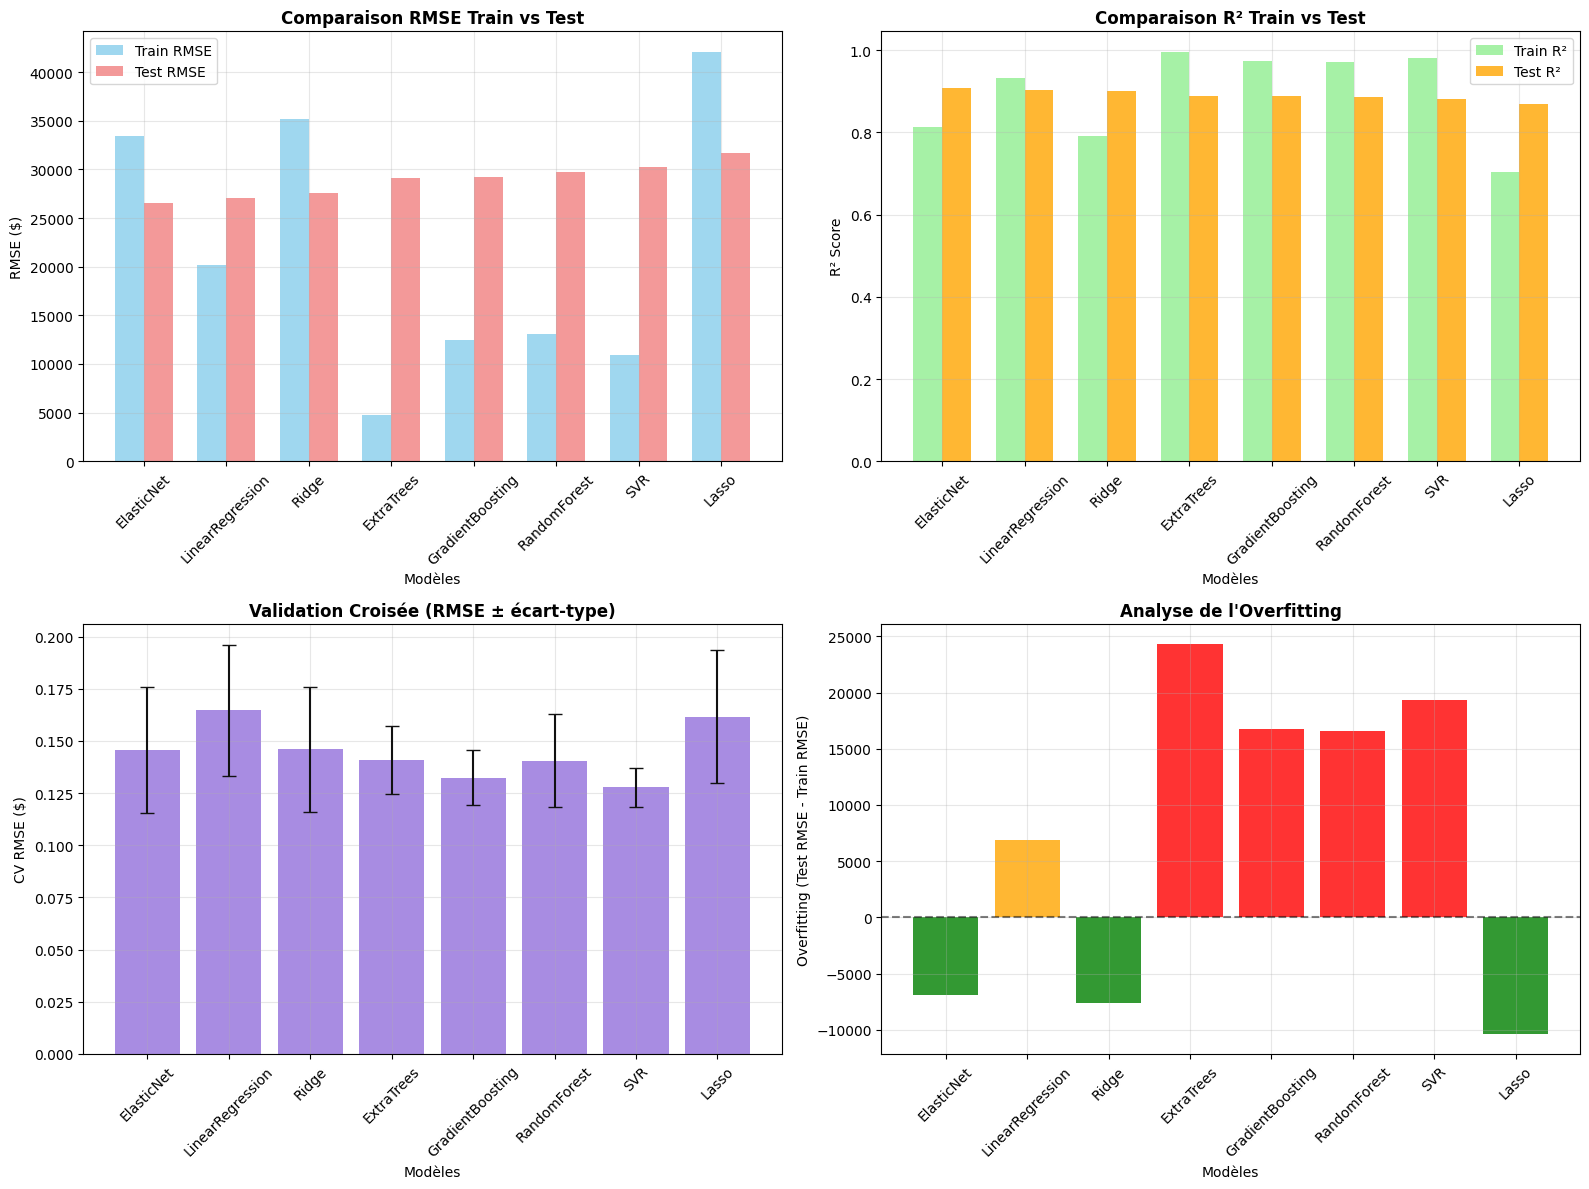

2025-07-28 18:23:04.869 | INFO     | __main__:<module>:121 - Comparaison terminée. Meilleur modèle: ElasticNet (RMSE: $26,604.10)



Top 3 des modèles pour analyse multi-critères:
4. ElasticNet - RMSE: $26,604, R²: 0.908
1. LinearRegression - RMSE: $27,071, R²: 0.904
2. Ridge - RMSE: $27,605, R²: 0.901

Tableau de comparaison sauvegardé: d:\Documents\IT\mlops_house_price_prediction\output_files\house_price_02_essais_comparaison.csv


In [8]:
print("\n=== COMPARAISON DES RÉSULTATS ===")

if len(results) == 0:
    print("Aucun modèle n'a été entraîné avec succès.")
    logger.error("Aucun résultat disponible pour la comparaison")
else:
    # Création d'un DataFrame de comparaison
    comparison_data = []

    for model_name, result in results.items():
        comparison_data.append(
            {
                "Modèle": model_name,
                "Train_RMSE": result["train_metrics"]["RMSE"],
                "Test_RMSE": result["test_metrics"]["RMSE"],
                "Train_R2": result["train_metrics"]["R2"],
                "Test_R2": result["test_metrics"]["R2"],
                "Test_MAE": result["test_metrics"]["MAE"],
                "Test_MAPE": result["test_metrics"]["MAPE"],
                "CV_RMSE_Mean": result["cv_rmse_mean"],
                "CV_RMSE_Std": result["cv_rmse_std"],
                "Overfitting": result["test_metrics"]["RMSE"]
                - result["train_metrics"]["RMSE"],
            }
        )

    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values("Test_RMSE")

    print("\nTableau de comparaison des modèles:")
    print(comparison_df.round(4))

    # Identification du meilleur modèle
    best_model_name = comparison_df.iloc[0]["Modèle"]
    best_model_rmse = comparison_df.iloc[0]["Test_RMSE"]
    best_model_r2 = comparison_df.iloc[0]["Test_R2"]

    print(f"\n🏆 MEILLEUR MODÈLE: {best_model_name}")
    print(f"   Test RMSE: ${best_model_rmse:,.2f}")
    print(f"   Test R²: {best_model_r2:.4f}")
    print(f"   Test MAE: ${comparison_df.iloc[0]['Test_MAE']:,.2f}")
    print(f"   Test MAPE: {comparison_df.iloc[0]['Test_MAPE']:.2f}%")

    # Visualisations comparatives
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Comparaison RMSE Train vs Test
    x_pos = np.arange(len(comparison_df))
    width = 0.35

    axes[0, 0].bar(
        x_pos - width / 2,
        comparison_df["Train_RMSE"],
        width,
        label="Train RMSE",
        alpha=0.8,
        color="skyblue",
    )
    axes[0, 0].bar(
        x_pos + width / 2,
        comparison_df["Test_RMSE"],
        width,
        label="Test RMSE",
        alpha=0.8,
        color="lightcoral",
    )
    axes[0, 0].set_xlabel("Modèles")
    axes[0, 0].set_ylabel("RMSE ($)")
    axes[0, 0].set_title("Comparaison RMSE Train vs Test", fontweight="bold")
    axes[0, 0].set_xticks(x_pos)
    axes[0, 0].set_xticklabels(comparison_df["Modèle"], rotation=45)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Comparaison R² Train vs Test
    axes[0, 1].bar(
        x_pos - width / 2,
        comparison_df["Train_R2"],
        width,
        label="Train R²",
        alpha=0.8,
        color="lightgreen",
    )
    axes[0, 1].bar(
        x_pos + width / 2,
        comparison_df["Test_R2"],
        width,
        label="Test R²",
        alpha=0.8,
        color="orange",
    )
    axes[0, 1].set_xlabel("Modèles")
    axes[0, 1].set_ylabel("R² Score")
    axes[0, 1].set_title("Comparaison R² Train vs Test", fontweight="bold")
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels(comparison_df["Modèle"], rotation=45)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Validation croisée avec barres d'erreur
    axes[1, 0].bar(
        x_pos,
        comparison_df["CV_RMSE_Mean"],
        yerr=comparison_df["CV_RMSE_Std"],
        alpha=0.8,
        color="mediumpurple",
        capsize=5,
    )
    axes[1, 0].set_xlabel("Modèles")
    axes[1, 0].set_ylabel("CV RMSE ($)")
    axes[1, 0].set_title("Validation Croisée (RMSE ± écart-type)", fontweight="bold")
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(comparison_df["Modèle"], rotation=45)
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Analyse de l'overfitting
    colors = [
        "green" if x < 5000 else "orange" if x < 10000 else "red"
        for x in comparison_df["Overfitting"]
    ]
    axes[1, 1].bar(x_pos, comparison_df["Overfitting"], alpha=0.8, color=colors)
    axes[1, 1].set_xlabel("Modèles")
    axes[1, 1].set_ylabel("Overfitting (Test RMSE - Train RMSE)")
    axes[1, 1].set_title("Analyse de l'Overfitting", fontweight="bold")
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(comparison_df["Modèle"], rotation=45)
    axes[1, 1].axhline(y=0, color="black", linestyle="--", alpha=0.5)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Graphique radar pour comparaison multi-critères
    if len(results) >= 3:
        # Normalisation des métriques pour le graphique radar
        metrics_for_radar = ["Test_R2", "CV_RMSE_Mean", "Test_MAE", "Test_MAPE"]
        top_3_models = comparison_df.head(3)

        # Inversion et normalisation pour que "plus haut = mieux" pour toutes les métriques
        radar_data = top_3_models.copy()
        radar_data["Test_R2_norm"] = radar_data["Test_R2"]  # Plus haut = mieux
        radar_data["CV_RMSE_inv"] = 1 / (
            1 + radar_data["CV_RMSE_Mean"] / 10000
        )  # Inversion
        radar_data["MAE_inv"] = 1 / (1 + radar_data["Test_MAE"] / 10000)  # Inversion
        radar_data["MAPE_inv"] = 1 / (1 + radar_data["Test_MAPE"] / 100)  # Inversion

        print("\nTop 3 des modèles pour analyse multi-critères:")
        for i, row in top_3_models.iterrows():
            print(
                f"{i+1}. {row['Modèle']} - RMSE: ${row['Test_RMSE']:,.0f}, R²: {row['Test_R2']:.3f}"
            )

    # Sauvegarde des résultats de comparaison
    comparison_file = OUTPUT_DIR / "house_price_02_essais_comparaison.csv"
    comparison_df.to_csv(comparison_file, index=False)
    print(f"\nTableau de comparaison sauvegardé: {comparison_file}")

    logger.info(
        f"Comparaison terminée. Meilleur modèle: {best_model_name} (RMSE: ${best_model_rmse:,.2f})"
    )

# Analyse approfondie du meilleur modèle


=== ANALYSE APPROFONDIE DU MEILLEUR MODÈLE ===
Analyse détaillée du modèle: ElasticNet
Description: Régression ElasticNet combinant L1 et L2


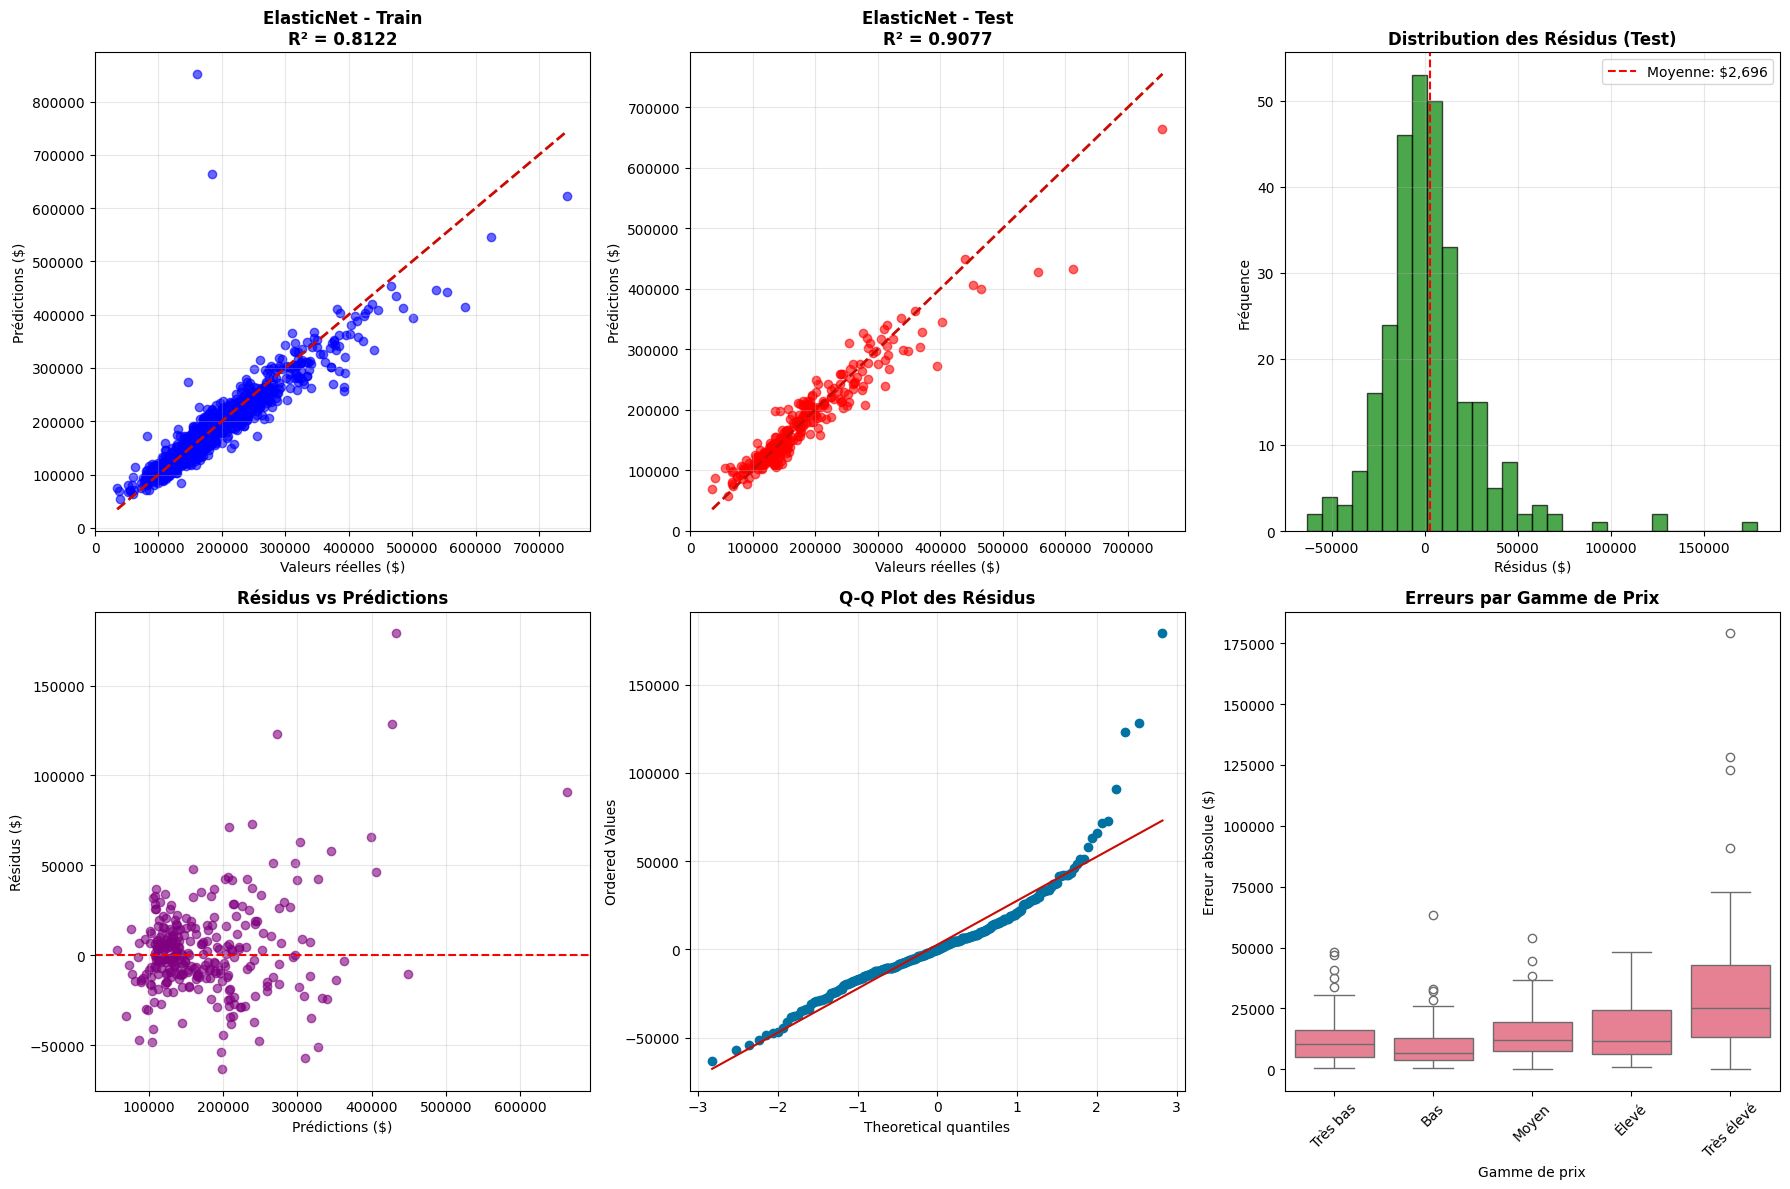

2025-07-28 18:23:18.508 | INFO     | __main__:<module>:126 - Analyse du meilleur modèle terminée. Résidus moyens: $2,696



Analyse des résidus:
Moyenne des résidus: $2,695.82
Écart-type des résidus: $26,512.60
Résidu médian: $-119.74
MAE: $17,718.03

Test de normalité des résidus (Shapiro-Wilk):
Statistique: 0.8779
p-value: 0.000000
Résidus normalement distribués: Non (α = 0.05)

Analyse des erreurs importantes:
Seuil (95e percentile): $49,482
Nombre d'erreurs importantes: 15 (5.1%)
Erreur maximale: $179,034
Prix réels avec grandes erreurs: $135,000 - $755,000


In [9]:
print("\n=== ANALYSE APPROFONDIE DU MEILLEUR MODÈLE ===")

if len(results) > 0:
    best_model = trained_models[best_model_name]
    best_results = results[best_model_name]

    print(f"Analyse détaillée du modèle: {best_model_name}")
    print(f"Description: {models[best_model_name]['description']}")

    # Prédictions du meilleur modèle
    y_train_pred_best = best_results["y_train_pred"]
    y_test_pred_best = best_results["y_test_pred"]

    # Reconversion si transformation log utilisée
    if use_log_transform:
        y_train_orig = np.expm1(y_train)
        y_test_orig = np.expm1(y_test)
        y_train_pred_orig = np.expm1(y_train_pred_best)
        y_test_pred_orig = np.expm1(y_test_pred_best)
    else:
        y_train_orig = y_train
        y_test_orig = y_test
        y_train_pred_orig = y_train_pred_best
        y_test_pred_orig = y_test_pred_best

    # Visualisations détaillées
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Prédictions vs Valeurs réelles (Train)
    axes[0, 0].scatter(y_train_orig, y_train_pred_orig, alpha=0.6, color="blue")
    axes[0, 0].plot(
        [y_train_orig.min(), y_train_orig.max()],
        [y_train_orig.min(), y_train_orig.max()],
        "r--",
        lw=2,
    )
    axes[0, 0].set_xlabel("Valeurs réelles ($)")
    axes[0, 0].set_ylabel("Prédictions ($)")
    axes[0, 0].set_title(
        f'{best_model_name} - Train\nR² = {best_results["train_metrics"]["R2"]:.4f}',
        fontweight="bold",
    )
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Prédictions vs Valeurs réelles (Test)
    axes[0, 1].scatter(y_test_orig, y_test_pred_orig, alpha=0.6, color="red")
    axes[0, 1].plot(
        [y_test_orig.min(), y_test_orig.max()],
        [y_test_orig.min(), y_test_orig.max()],
        "r--",
        lw=2,
    )
    axes[0, 1].set_xlabel("Valeurs réelles ($)")
    axes[0, 1].set_ylabel("Prédictions ($)")
    axes[0, 1].set_title(
        f'{best_model_name} - Test\nR² = {best_results["test_metrics"]["R2"]:.4f}',
        fontweight="bold",
    )
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Distribution des résidus (Test)
    residuals_test = y_test_orig - y_test_pred_orig
    axes[0, 2].hist(
        residuals_test, bins=30, alpha=0.7, color="green", edgecolor="black"
    )
    axes[0, 2].axvline(
        residuals_test.mean(),
        color="red",
        linestyle="--",
        label=f"Moyenne: ${residuals_test.mean():,.0f}",
    )
    axes[0, 2].set_xlabel("Résidus ($)")
    axes[0, 2].set_ylabel("Fréquence")
    axes[0, 2].set_title("Distribution des Résidus (Test)", fontweight="bold")
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Résidus vs Prédictions
    axes[1, 0].scatter(y_test_pred_orig, residuals_test, alpha=0.6, color="purple")
    axes[1, 0].axhline(y=0, color="red", linestyle="--")
    axes[1, 0].set_xlabel("Prédictions ($)")
    axes[1, 0].set_ylabel("Résidus ($)")
    axes[1, 0].set_title("Résidus vs Prédictions", fontweight="bold")
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Q-Q plot des résidus
    stats.probplot(residuals_test, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title("Q-Q Plot des Résidus", fontweight="bold")
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Erreurs absolues par gamme de prix
    price_bins = pd.qcut(
        y_test_orig, q=5, labels=["Très bas", "Bas", "Moyen", "Élevé", "Très élevé"]
    )
    abs_errors = np.abs(residuals_test)

    error_by_price = pd.DataFrame({"price_bin": price_bins, "abs_error": abs_errors})

    sns.boxplot(data=error_by_price, x="price_bin", y="abs_error", ax=axes[1, 2])
    axes[1, 2].set_xlabel("Gamme de prix")
    axes[1, 2].set_ylabel("Erreur absolue ($)")
    axes[1, 2].set_title("Erreurs par Gamme de Prix", fontweight="bold")
    axes[1, 2].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()

    # Analyse des résidus
    print("\nAnalyse des résidus:")
    print(f"Moyenne des résidus: ${residuals_test.mean():,.2f}")
    print(f"Écart-type des résidus: ${residuals_test.std():,.2f}")
    print(f"Résidu médian: ${np.median(residuals_test):,.2f}")
    print(f"MAE: ${np.mean(np.abs(residuals_test)):,.2f}")

    # Test de normalité des résidus
    from scipy.stats import shapiro, normaltest

    if len(residuals_test) <= 5000:  # Shapiro-Wilk pour petits échantillons
        stat, p_value = shapiro(residuals_test)
        test_name = "Shapiro-Wilk"
    else:  # D'Agostino pour grands échantillons
        stat, p_value = normaltest(residuals_test)
        test_name = "D'Agostino"

    print(f"\nTest de normalité des résidus ({test_name}):")
    print(f"Statistique: {stat:.4f}")
    print(f"p-value: {p_value:.6f}")
    print(
        f"Résidus normalement distribués: {'Oui' if p_value > 0.05 else 'Non'} (α = 0.05)"
    )

    # Analyse des erreurs importantes
    large_errors_threshold = np.percentile(np.abs(residuals_test), 95)
    large_errors_mask = np.abs(residuals_test) > large_errors_threshold
    n_large_errors = np.sum(large_errors_mask)

    print("\nAnalyse des erreurs importantes:")
    print(f"Seuil (95e percentile): ${large_errors_threshold:,.0f}")
    print(
        f"Nombre d'erreurs importantes: {n_large_errors} ({n_large_errors/len(residuals_test)*100:.1f}%)"
    )

    if n_large_errors > 0:
        print(f"Erreur maximale: ${np.max(np.abs(residuals_test)):,.0f}")
        print(
            f"Prix réels avec grandes erreurs: ${y_test_orig[large_errors_mask].min():,.0f} - ${y_test_orig[large_errors_mask].max():,.0f}"
        )

    logger.info(
        f"Analyse du meilleur modèle terminée. Résidus moyens: ${residuals_test.mean():,.0f}"
    )

else:
    print("Aucun modèle disponible pour l'analyse.")
    logger.error("Aucun modèle disponible pour l'analyse approfondie")

# Analyse de l'importance des features


=== ANALYSE DE L'IMPORTANCE DES FEATURES ===
Top 20 des coefficients les plus importants pour ElasticNet:
                   feature  coefficient  abs_coefficient
2                GrLivArea     0.089026         0.089026
87     Exterior1st_BrkFace     0.073863         0.073863
0              OverallQual     0.072763         0.072763
3               GarageCars     0.072264         0.072264
8             QualityScore     0.070281         0.070281
19             MSZoning_RM    -0.060621         0.060621
42         Condition1_Norm     0.054219         0.054219
57           BldgType_1Fam     0.053988         0.053988
129            BsmtQual_Ex     0.052338         0.052338
76        RoofMatl_ClyTile    -0.047963         0.047963
180         Functional_Typ     0.047012         0.047012
170         KitchenQual_Ex     0.044958         0.044958
217  SaleCondition_Abnorml    -0.039411         0.039411
164           CentralAir_N    -0.038936         0.038936
165           CentralAir_Y     0.03893

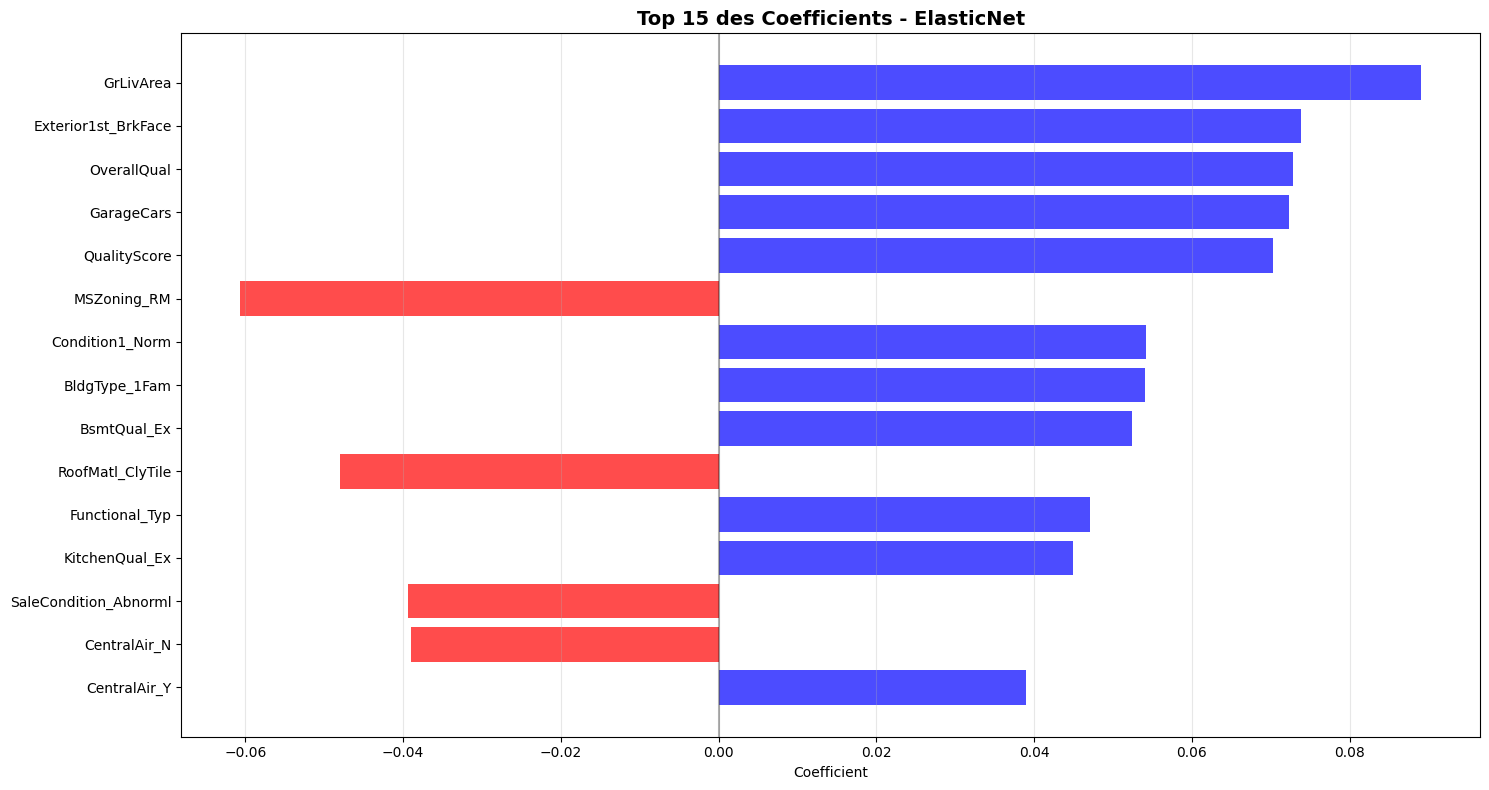

2025-07-28 18:24:06.524 | INFO     | __main__:<module>:98 - Analyse des coefficients terminée. Top coefficient: GrLivArea (0.0890)



Coefficients sauvegardés: d:\Documents\IT\mlops_house_price_prediction\output_files\house_price_02_essais_coefficients_ElasticNet.csv


In [10]:
print("\n=== ANALYSE DE L'IMPORTANCE DES FEATURES ===")

if len(results) > 0 and hasattr(
    best_model.named_steps["regressor"], "feature_importances_"
):
    # Extraction des importances des features pour les modèles basés sur les arbres
    feature_importances = best_model.named_steps["regressor"].feature_importances_

    # Création d'un DataFrame pour l'analyse
    importance_df = pd.DataFrame(
        {"feature": all_feature_names, "importance": feature_importances}
    ).sort_values("importance", ascending=False)

    print(f"Top 20 des features les plus importantes pour {best_model_name}:")
    print(importance_df.head(20))

    # Visualisation des importances
    plt.figure(figsize=FIGSIZE_LARGE)
    top_features = importance_df.head(15)

    plt.barh(range(len(top_features)), top_features["importance"], color="steelblue")
    plt.yticks(range(len(top_features)), top_features["feature"])
    plt.xlabel("Importance")
    plt.title(
        f"Top 15 des Features les Plus Importantes - {best_model_name}",
        fontweight="bold",
        fontsize=14,
    )
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis="x")
    plt.tight_layout()
    plt.show()

    # Analyse cumulative de l'importance
    importance_df["cumulative_importance"] = importance_df["importance"].cumsum()

    # Nombre de features pour atteindre 80% et 95% de l'importance
    features_80 = len(importance_df[importance_df["cumulative_importance"] <= 0.8])
    features_95 = len(importance_df[importance_df["cumulative_importance"] <= 0.95])

    print("\nAnalyse cumulative de l'importance:")
    print(
        f"Features pour 80% de l'importance: {features_80} ({features_80/len(all_feature_names)*100:.1f}%)"
    )
    print(
        f"Features pour 95% de l'importance: {features_95} ({features_95/len(all_feature_names)*100:.1f}%)"
    )

    # Graphique de l'importance cumulative
    plt.figure(figsize=FIGSIZE_MEDIUM)
    plt.plot(
        range(1, len(importance_df) + 1),
        importance_df["cumulative_importance"],
        marker="o",
        markersize=3,
        linewidth=2,
        color="darkgreen",
    )
    plt.axhline(y=0.8, color="red", linestyle="--", alpha=0.7, label="80%")
    plt.axhline(y=0.95, color="orange", linestyle="--", alpha=0.7, label="95%")
    plt.axvline(x=features_80, color="red", linestyle=":", alpha=0.7)
    plt.axvline(x=features_95, color="orange", linestyle=":", alpha=0.7)
    plt.xlabel("Nombre de Features")
    plt.ylabel("Importance Cumulative")
    plt.title("Importance Cumulative des Features", fontweight="bold")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Sauvegarde des importances
    importance_file = (
        OUTPUT_DIR / f"house_price_02_essais_feature_importance_{best_model_name}.csv"
    )
    importance_df.to_csv(importance_file, index=False)
    print(f"\nImportances des features sauvegardées: {importance_file}")

    logger.info(
        f"Analyse des features terminée. Top feature: {importance_df.iloc[0]['feature']} ({importance_df.iloc[0]['importance']:.4f})"
    )

elif len(results) > 0:
    # Pour les modèles linéaires, analyser les coefficients
    if hasattr(best_model.named_steps["regressor"], "coef_"):
        coefficients = best_model.named_steps["regressor"].coef_

        coef_df = pd.DataFrame(
            {
                "feature": all_feature_names,
                "coefficient": coefficients,
                "abs_coefficient": np.abs(coefficients),
            }
        ).sort_values("abs_coefficient", ascending=False)

        print(f"Top 20 des coefficients les plus importants pour {best_model_name}:")
        print(coef_df.head(20))

        # Visualisation des coefficients
        plt.figure(figsize=FIGSIZE_LARGE)
        top_coefs = coef_df.head(15)

        colors = ["red" if x < 0 else "blue" for x in top_coefs["coefficient"]]
        plt.barh(
            range(len(top_coefs)), top_coefs["coefficient"], color=colors, alpha=0.7
        )
        plt.yticks(range(len(top_coefs)), top_coefs["feature"])
        plt.xlabel("Coefficient")
        plt.title(
            f"Top 15 des Coefficients - {best_model_name}",
            fontweight="bold",
            fontsize=14,
        )
        plt.gca().invert_yaxis()
        plt.axvline(x=0, color="black", linestyle="-", alpha=0.3)
        plt.grid(True, alpha=0.3, axis="x")
        plt.tight_layout()
        plt.show()

        # Sauvegarde des coefficients
        coef_file = (
            OUTPUT_DIR / f"house_price_02_essais_coefficients_{best_model_name}.csv"
        )
        coef_df.to_csv(coef_file, index=False)
        print(f"\nCoefficients sauvegardés: {coef_file}")

        logger.info(
            f"Analyse des coefficients terminée. Top coefficient: {coef_df.iloc[0]['feature']} ({coef_df.iloc[0]['coefficient']:.4f})"
        )

    else:
        print(
            f"Le modèle {best_model_name} ne fournit pas d'informations sur l'importance des features."
        )
        logger.info(f"Pas d'analyse d'importance disponible pour {best_model_name}")

else:
    print("Aucun modèle disponible pour l'analyse des features.")
    logger.error("Aucun modèle disponible pour l'analyse des features")

# Sauvegarde du modèle final et préparation pour le déploiement

In [11]:
print("\n=== SAUVEGARDE DU MODÈLE FINAL ===")

if len(results) > 0:
    # Sauvegarde du meilleur modèle avec pickle
    model_file = MODELS_DIR / f"house_price_best_model_{best_model_name.lower()}.pkl"

    with open(model_file, "wb") as f:
        pickle.dump(best_model, f)

    print(f"Meilleur modèle sauvegardé: {model_file}")

    # Sauvegarde des métadonnées du modèle
    model_metadata = {
        "model_name": best_model_name,
        "model_type": type(best_model.named_steps["regressor"]).__name__,
        "training_date": CURRENT_DATE.isoformat(),
        "target_variable": TARGET_VARIABLE,
        "use_log_transform": use_log_transform,
        "features": {
            "numeric_features": numeric_features,
            "categorical_features": categorical_features,
            "total_features": len(selected_features),
            "final_features_count": len(all_feature_names),
        },
        "performance": {
            "test_rmse": float(best_results["test_metrics"]["RMSE"]),
            "test_r2": float(best_results["test_metrics"]["R2"]),
            "test_mae": float(best_results["test_metrics"]["MAE"]),
            "test_mape": float(best_results["test_metrics"]["MAPE"]),
            "cv_rmse_mean": float(best_results["cv_rmse_mean"]),
            "cv_rmse_std": float(best_results["cv_rmse_std"]),
        },
        "data_info": {
            "train_size": X_train.shape[0],
            "test_size": X_test.shape[0],
            "total_size": len(X_selected),
        },
        "preprocessing": {
            "numeric_imputation": "median",
            "numeric_scaling": "RobustScaler",
            "categorical_imputation": "most_frequent",
            "categorical_encoding": "OneHotEncoder",
        },
    }

    metadata_file = (
        MODELS_DIR / f"house_price_best_model_{best_model_name.lower()}_metadata.json"
    )
    with open(metadata_file, "w") as f:
        json.dump(model_metadata, f, indent=2)

    print(f"Métadonnées du modèle sauvegardées: {metadata_file}")

    # Création d'un fichier de prédiction d'exemple
    example_data = X_test.head(5).copy()
    example_predictions = best_model.predict(example_data)

    if use_log_transform:
        example_predictions_orig = np.expm1(example_predictions)
        example_actual_orig = np.expm1(y_test.head(5))
    else:
        example_predictions_orig = example_predictions
        example_actual_orig = y_test.head(5)

    example_results = pd.DataFrame(
        {
            "Actual_Price": example_actual_orig,
            "Predicted_Price": example_predictions_orig,
            "Absolute_Error": np.abs(example_actual_orig - example_predictions_orig),
            "Percentage_Error": np.abs(example_actual_orig - example_predictions_orig)
            / example_actual_orig
            * 100,
        }
    )

    # Ajout des features principales pour contexte
    main_features = (
        ["GrLivArea", "OverallQual", "YearBuilt"]
        if all(
            f in example_data.columns for f in ["GrLivArea", "OverallQual", "YearBuilt"]
        )
        else example_data.columns[:3]
    )
    for feature in main_features:
        if feature in example_data.columns:
            example_results[feature] = example_data[feature].values

    example_file = OUTPUT_DIR / "house_price_02_essais_predictions_exemple.csv"
    example_results.to_csv(example_file, index=False)

    print("\nExemples de prédictions:")
    print(example_results.round(2))
    print(f"\nExemples de prédictions sauvegardés: {example_file}")

    # Résumé final
    print(f"\n{'='*80}")
    print("RÉSUMÉ DE L'EXPÉRIMENTATION")
    print(f"{'='*80}")
    print(f"Modèles testés: {len(results)}")
    print(f"Meilleur modèle: {best_model_name}")
    print("Performance (Test):")
    print(f"  - RMSE: ${best_results['test_metrics']['RMSE']:,.2f}")
    print(f"  - R²: {best_results['test_metrics']['R2']:.4f}")
    print(f"  - MAE: ${best_results['test_metrics']['MAE']:,.2f}")
    print(f"  - MAPE: {best_results['test_metrics']['MAPE']:.2f}%")
    print("Validation croisée:")
    print(
        f"  - CV RMSE: ${best_results['cv_rmse_mean']:,.2f} (±${best_results['cv_rmse_std']:,.2f})"
    )
    print(
        f"Features utilisées: {len(selected_features)} → {len(all_feature_names)} (après preprocessing)"
    )
    print(f"Transformation log: {'Oui' if use_log_transform else 'Non'}")

    # Instructions pour le déploiement
    print(f"\n{'='*80}")
    print("INSTRUCTIONS POUR LE DÉPLOIEMENT")
    print(f"{'='*80}")
    print(f"1. Modèle sauvegardé: {model_file}")
    print(f"2. Métadonnées: {metadata_file}")
    print("3. Pour charger le modèle:")
    print(f"   with open('{model_file}', 'rb') as f:")
    print("       model = pickle.load(f)")
    print("4. Pour faire une prédiction:")
    print("   prediction = model.predict(new_data)")
    if use_log_transform:
        print("   price = np.expm1(prediction)  # Reconversion depuis log")
    print(f"5. Features requises: {len(selected_features)} variables")
    print(f"   - Numériques: {numeric_features[:5]}...")
    print(f"   - Catégorielles: {categorical_features[:3]}...")

    logger.info(
        f"Modèle final sauvegardé: {best_model_name} (RMSE: ${best_results['test_metrics']['RMSE']:,.2f})"
    )

else:
    print("Aucun modèle à sauvegarder.")
    logger.error("Aucun modèle disponible pour la sauvegarde")

print(f"\n{'='*80}")
print("EXPÉRIMENTATION TERMINÉE AVEC SUCCÈS")
print(f"{'='*80}")

logger.info("Expérimentation terminée avec succès")

2025-07-28 18:24:30.512 | INFO     | __main__:<module>:116 - Modèle final sauvegardé: ElasticNet (RMSE: $26,604.10)
2025-07-28 18:24:30.516 | INFO     | __main__:<module>:126 - Expérimentation terminée avec succès



=== SAUVEGARDE DU MODÈLE FINAL ===
Meilleur modèle sauvegardé: d:\Documents\IT\mlops_house_price_prediction\models\house_price_best_model_elasticnet.pkl
Métadonnées du modèle sauvegardées: d:\Documents\IT\mlops_house_price_prediction\models\house_price_best_model_elasticnet_metadata.json

Exemples de prédictions:
      Actual_Price  Predicted_Price  Absolute_Error  Percentage_Error  \
892       154500.0        154322.45          177.55              0.11   
1105      325000.0        317413.86         7586.14              2.33   
413       115000.0        102825.42        12174.58             10.59   
522       159000.0        147941.60        11058.40              6.95   
1036      315500.0        340017.12        24517.12              7.77   

      GrLivArea  OverallQual  YearBuilt  
892        1068            6       1963  
1105       2622            8       1994  
413        1028            5       1927  
522        1664            6       1947  
1036       1620            9       